In [1]:
import pyspark as ps
import json
import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

In [99]:
spark = (ps.sql.SparkSession.builder 
        .master("local[4]").
         config("spark.driver.memory", "15g")
        .appName("recommender") 
        .getOrCreate()
        )

In [3]:
sc = spark.sparkContext

## Bundle

In [4]:
bundle_rdd= sc.textFile('data/bundle_data.json')


In [5]:
bundle_rdd.count()

615

In [6]:
bundle_rdd.first()

"{'bundle_final_price': '$66.46', 'bundle_url': 'http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page', 'bundle_price': '$73.86', 'bundle_name': 'Dharker Studio 2015 Complete', 'bundle_id': '450', 'items': [{'genre': 'Adventure, Indie, RPG', 'item_id': '326950', 'discounted_price': '$8.99', 'item_url': 'http://store.steampowered.com/app/326950', 'item_name': 'Sword of Asumi'}, {'genre': 'Adventure, Indie, RPG', 'item_id': '331490', 'discounted_price': '$2.99', 'item_url': 'http://store.steampowered.com/app/331490', 'item_name': 'Sword of Asumi - Soundtrack'}, {'genre': 'Adventure, Indie, RPG', 'item_id': '331491', 'discounted_price': '$1.99', 'item_url': 'http://store.steampowered.com/app/331491', 'item_name': 'Sword of Asumi - Graphic Novel'}, {'genre': 'Adventure, Indie, RPG', 'item_id': '331492', 'discounted_price': '$0.99', 'item_url': 'http://store.steampowered.com/app/331492', 'item_name': 'Sword of Asumi - Characte

In [7]:
bundle_rdd = bundle_rdd.map(lambda x: ast.literal_eval(x))

In [8]:
bundle_rdd.first()

{'bundle_final_price': '$66.46',
 'bundle_url': 'http://store.steampowered.com/bundle/450/?utm_source=SteamDB&utm_medium=SteamDB&utm_campaign=SteamDB%20Bundles%20Page',
 'bundle_price': '$73.86',
 'bundle_name': 'Dharker Studio 2015 Complete',
 'bundle_id': '450',
 'items': [{'genre': 'Adventure, Indie, RPG',
   'item_id': '326950',
   'discounted_price': '$8.99',
   'item_url': 'http://store.steampowered.com/app/326950',
   'item_name': 'Sword of Asumi'},
  {'genre': 'Adventure, Indie, RPG',
   'item_id': '331490',
   'discounted_price': '$2.99',
   'item_url': 'http://store.steampowered.com/app/331490',
   'item_name': 'Sword of Asumi - Soundtrack'},
  {'genre': 'Adventure, Indie, RPG',
   'item_id': '331491',
   'discounted_price': '$1.99',
   'item_url': 'http://store.steampowered.com/app/331491',
   'item_name': 'Sword of Asumi - Graphic Novel'},
  {'genre': 'Adventure, Indie, RPG',
   'item_id': '331492',
   'discounted_price': '$0.99',
   'item_url': 'http://store.steampowered.c

In [9]:
bundle = bundle_rdd.toDF()

/usr/local/spark/python/pyspark/sql/session.py:398: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [10]:
bundle.columns

['bundle_discount',
 'bundle_final_price',
 'bundle_id',
 'bundle_name',
 'bundle_price',
 'bundle_url',
 'items']

In [11]:
bundle.show(5)

+---------------+------------------+---------+--------------------+------------+--------------------+--------------------+
|bundle_discount|bundle_final_price|bundle_id|         bundle_name|bundle_price|          bundle_url|               items|
+---------------+------------------+---------+--------------------+------------+--------------------+--------------------+
|            10%|            $66.46|      450|Dharker Studio 20...|      $73.86|http://store.stea...|[[genre -> Advent...|
|            22%|            $20.15|     1473|Naruto Shippuden ...|      $25.87|http://store.stea...|[[genre -> , item...|
|            22%|            $20.15|     1474|Naruto Shippuden ...|      $25.87|http://store.stea...|[[genre -> , item...|
|            40%|            $15.17|     1437|Pixel Puzzles Ult...|      $25.35|http://store.stea...|[[genre -> Casual...|
|            22%|            $20.15|     1466|Naruto Shippuden ...|      $25.87|http://store.stea...|[[genre -> , item...|
+---------------

In [12]:
bundle_pd = bundle.select("*").toPandas()

In [13]:
bundle_pd.head()

,bundle_discount,bundle_final_price,bundle_id,bundle_name,bundle_price,bundle_url,items
0,10%,$66.46,450,Dharker Studio 2015 Complete,$73.86,http://store.steampowered.com/bundle/450/?utm_...,"[{'genre': 'Adventure, Indie, RPG', 'item_name..."
1,22%,$20.15,1473,"Naruto Shippuden Uncut Season 4, Vol. 3",$25.87,http://store.steampowered.com/bundle/1473/?utm...,"[{'genre': '', 'item_name': 'Naruto Shippuden ..."
2,22%,$20.15,1474,"Naruto Shippuden Uncut Season 4, Vol. 4",$25.87,http://store.steampowered.com/bundle/1474/?utm...,"[{'genre': '', 'item_name': 'Naruto Shippuden ..."
3,40%,$15.17,1437,Pixel Puzzles Ultimate: Starter Kit,$25.35,http://store.steampowered.com/bundle/1437/?utm...,"[{'genre': 'Casual, Free to Play, Indie, Simul..."
4,22%,$20.15,1466,"Naruto Shippuden Uncut Season 4, Vol. 1",$25.87,http://store.steampowered.com/bundle/1466/?utm...,"[{'genre': '', 'item_name': 'Naruto Shippuden ..."


In [14]:
dfs = []
for i in range(bundle_pd.shape[0]):
    df = pd.DataFrame(bundle_pd['items'][i])
    df['bundle_id']= bundle_pd['bundle_id'][i]
    dfs.append(df)


In [15]:
bundle_pd = pd.concat(dfs)

In [16]:
bundle_pd.reset_index(inplace= True)


In [17]:
bundle_pd.columns

Index(['index', 'genre', 'item_name', 'item_id', 'item_url',
       'discounted_price', 'bundle_id'],
      dtype='object')

In [18]:
bundle_pd.drop(['index'],axis = 1, inplace=True)

In [19]:
bundle_pd

,genre,item_name,item_id,item_url,discounted_price,bundle_id
0,"Adventure, Indie, RPG",Sword of Asumi,326950,http://store.steampowered.com/app/326950,$8.99,450
1,"Adventure, Indie, RPG",Sword of Asumi - Soundtrack,331490,http://store.steampowered.com/app/331490,$2.99,450
2,"Adventure, Indie, RPG",Sword of Asumi - Graphic Novel,331491,http://store.steampowered.com/app/331491,$1.99,450
3,"Adventure, Indie, RPG",Sword of Asumi - Character Creator,331492,http://store.steampowered.com/app/331492,$0.99,450
4,"Adventure, Casual, Indie",Divine Slice of Life,348540,http://store.steampowered.com/app/348540,$12.99,450
...,...,...,...,...,...,...
3520,"Action, Adventure, Casual, Indie",Dyna Bomb,467220,http://store.steampowered.com/app/467220,$4.99,588
3521,"Action, Adventure, Casual, Indie",Dyna Bomb - Soundtrack OST,485090,http://store.steampowered.com/app/485090,$1.99,588
3522,"Action, Adventure, Indie",Ninjahtic,385230,http://store.steampowered.com/app/385230,$1.99,594
3523,"Action, Adventure, Indie",Ninjahtic Mind Tricks,387880,http://store.steampowered.com/app/387880,$1.99,594


#### Number of Bundles

In [20]:
bundle_pd['bundle_id'].nunique()

615

#### Number of Different Games

In [21]:
bundle_pd['item_id'].nunique()

2798

#### Number of Games from Bundle in User Reviews

In [87]:
bundle_pd.item_id.isin(user_reviews_pd.item_id).sum()

735

## Games

In [22]:
games_rdd = sc.textFile('data/steam_games (3).json')

In [23]:
games_rdd.count()

32135

In [24]:
games_rdd= games_rdd.map(lambda x: ast.literal_eval(x))

In [71]:
games = games_rdd.toDF()

In [72]:
games.show(1)

+-------------------+---------+--------------+------------+--------------------+------+-----+---------+------------+--------------------+---------------+--------------------+-------------------+--------------------+
|           app_name|developer|discount_price|early_access|              genres|    id|price|publisher|release_date|         reviews_url|          specs|                tags|              title|                 url|
+-------------------+---------+--------------+------------+--------------------+------+-----+---------+------------+--------------------+---------------+--------------------+-------------------+--------------------+
|Lost Summoner Kitty|Kotoshiro|          4.49|       false|[Action, Casual, ...|761140| 4.99|Kotoshiro|  2018-01-04|http://steamcommu...|[Single-player]|[Strategy, Action...|Lost Summoner Kitty|http://store.stea...|
+-------------------+---------+--------------+------------+--------------------+------+-----+---------+------------+--------------------

In [83]:
games.agg(countDistinct(col("id")).alias("count")).show()

+-----+
|count|
+-----+
|32132|
+-----+



## User Reviews

In [28]:
user_reviews_rdd= sc.textFile('data/australian_user_reviews (2).json')

In [29]:
user_reviews_rdd.count()

25799

In [30]:
user_reviews_rdd.first()

'{\'user_id\': \'76561197970982479\', \'user_url\': \'http://steamcommunity.com/profiles/76561197970982479\', \'reviews\': [{\'funny\': \'\', \'posted\': \'Posted November 5, 2011.\', \'last_edited\': \'\', \'item_id\': \'1250\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': \'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.\'}, {\'funny\': \'\', \'posted\': \'Posted July 15, 2011.\', \'last_edited\': \'\', \'item_id\': \'22200\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': "It\'s unique and worth a playthrough."}, {\'funny\': \'\', \'posted\': \'Posted April 21, 2011.\', \'last_edited\': \'\', \'item_id\': \'43110\', \'helpful\': \'No ratings yet\', \'recommend\': True, \'review\': \'Great atmosphere. The gunplay can be a bit chunky at times but 

In [31]:
user_reviews_rdd= user_reviews_rdd.map(lambda x: ast.literal_eval(x))

In [32]:
user_reviews_rdd.first()

{'user_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'reviews': [{'funny': '',
   'posted': 'Posted November 5, 2011.',
   'last_edited': '',
   'item_id': '1250',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'},
  {'funny': '',
   'posted': 'Posted July 15, 2011.',
   'last_edited': '',
   'item_id': '22200',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': "It's unique and worth a playthrough."},
  {'funny': '',
   'posted': 'Posted April 21, 2011.',
   'last_edited': '',
   'item_id': '43110',
   'helpful': 'No ratings yet',
   'recommend': True,
   'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this 

In [33]:
user_reviews = user_reviews_rdd.toDF()

In [34]:
user_reviews.show(1)

+--------------------+-----------------+--------------------+
|             reviews|          user_id|            user_url|
+--------------------+-----------------+--------------------+
|[[last_edited -> ...|76561197970982479|http://steamcommu...|
+--------------------+-----------------+--------------------+
only showing top 1 row



In [35]:
from pyspark.sql.functions import col, countDistinct


In [36]:
user_reviews.agg(countDistinct(col("user_id")).alias("count")).show()

+-----+
|count|
+-----+
|25485|
+-----+



In [37]:
from pyspark.sql.functions import explode

explodeDF = user_reviews.select(explode("reviews").alias("r"))
flattenDF = explodeDF.selectExpr('r.last_edited', 'r.item_id', 'r.review', 'r.recommend', 'r.helpful', 'r.funny',
       'r.posted', 'r.user_id')

flattenDF.show()


+--------------------+-------+--------------------+---------+--------------------+--------------------+--------------------+-------+
|         last_edited|item_id|              review|recommend|             helpful|               funny|              posted|user_id|
+--------------------+-------+--------------------+---------+--------------------+--------------------+--------------------+-------+
|                    |   1250|Simple yet with g...|     true|      No ratings yet|                    |Posted November 5...|   null|
|                    |  22200|It's unique and w...|     true|      No ratings yet|                    |Posted July 15, 2...|   null|
|                    |  43110|Great atmosphere....|     true|      No ratings yet|                    |Posted April 21, ...|   null|
|                    | 251610|I know what you t...|     true|15 of 20 people (...|                    |Posted June 24, 2...|   null|
|                    | 227300|For a simple (it'...|     true|0 of 1 p

In [38]:
flattenDF.count()

59305

In [39]:
user_reviews_pd = user_reviews.select("*").toPandas()

In [40]:
user_reviews_pd.head()

,reviews,user_id,user_url
0,"[{'last_edited': '', 'item_id': '1250', 'revie...",76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,"[{'last_edited': '', 'item_id': '251610', 'rev...",js41637,http://steamcommunity.com/id/js41637
2,"[{'last_edited': '', 'item_id': '248820', 'rev...",evcentric,http://steamcommunity.com/id/evcentric
3,"[{'last_edited': '', 'item_id': '250320', 'rev...",doctr,http://steamcommunity.com/id/doctr
4,"[{'last_edited': '', 'item_id': '211420', 'rev...",maplemage,http://steamcommunity.com/id/maplemage


In [41]:
user_reviews_pd.shape

(25799, 3)

In [42]:
user_reviews_pd.head()

,reviews,user_id,user_url
0,"[{'last_edited': '', 'item_id': '1250', 'revie...",76561197970982479,http://steamcommunity.com/profiles/76561197970...
1,"[{'last_edited': '', 'item_id': '251610', 'rev...",js41637,http://steamcommunity.com/id/js41637
2,"[{'last_edited': '', 'item_id': '248820', 'rev...",evcentric,http://steamcommunity.com/id/evcentric
3,"[{'last_edited': '', 'item_id': '250320', 'rev...",doctr,http://steamcommunity.com/id/doctr
4,"[{'last_edited': '', 'item_id': '211420', 'rev...",maplemage,http://steamcommunity.com/id/maplemage


In [43]:
dfs = []
for i in range(user_reviews_pd.shape[0]):
    df = pd.DataFrame(user_reviews_pd['reviews'][i])
    df['user_id']= user_reviews_pd['user_id'][i]
    dfs.append(df)


In [44]:
user_reviews_pd = pd.concat(dfs)

In [45]:
user_reviews_pd.head()

,last_edited,item_id,review,recommend,helpful,funny,posted,user_id
0,,1250,Simple yet with great replayability. In my opi...,true,No ratings yet,,"Posted November 5, 2011.",76561197970982479
1,,22200,It's unique and worth a playthrough.,true,No ratings yet,,"Posted July 15, 2011.",76561197970982479
2,,43110,Great atmosphere. The gunplay can be a bit chu...,true,No ratings yet,,"Posted April 21, 2011.",76561197970982479
0,,251610,I know what you think when you see this title ...,true,15 of 20 people (75%) found this review helpful,,"Posted June 24, 2014.",js41637
1,,227300,For a simple (it's actually not all that simpl...,true,0 of 1 people (0%) found this review helpful,,"Posted September 8, 2013.",js41637


In [46]:
user_reviews_pd.reset_index(inplace = True)

In [47]:
user_reviews_pd.head()

,index,last_edited,item_id,review,recommend,helpful,funny,posted,user_id
0,0,,1250,Simple yet with great replayability. In my opi...,true,No ratings yet,,"Posted November 5, 2011.",76561197970982479
1,1,,22200,It's unique and worth a playthrough.,true,No ratings yet,,"Posted July 15, 2011.",76561197970982479
2,2,,43110,Great atmosphere. The gunplay can be a bit chu...,true,No ratings yet,,"Posted April 21, 2011.",76561197970982479
3,0,,251610,I know what you think when you see this title ...,true,15 of 20 people (75%) found this review helpful,,"Posted June 24, 2014.",js41637
4,1,,227300,For a simple (it's actually not all that simpl...,true,0 of 1 people (0%) found this review helpful,,"Posted September 8, 2013.",js41637


In [48]:
user_reviews_pd.drop(['index'], axis = 1,inplace = True)

In [49]:
user_reviews_pd.head()

,last_edited,item_id,review,recommend,helpful,funny,posted,user_id
0,,1250,Simple yet with great replayability. In my opi...,true,No ratings yet,,"Posted November 5, 2011.",76561197970982479
1,,22200,It's unique and worth a playthrough.,true,No ratings yet,,"Posted July 15, 2011.",76561197970982479
2,,43110,Great atmosphere. The gunplay can be a bit chu...,true,No ratings yet,,"Posted April 21, 2011.",76561197970982479
3,,251610,I know what you think when you see this title ...,true,15 of 20 people (75%) found this review helpful,,"Posted June 24, 2014.",js41637
4,,227300,For a simple (it's actually not all that simpl...,true,0 of 1 people (0%) found this review helpful,,"Posted September 8, 2013.",js41637


In [50]:
user_reviews_pd.shape

(59305, 8)

In [51]:
user_reviews_pd['user_id'].nunique()

25458

In [52]:
user_reviews_pd['item_id'].nunique()

3682

In [53]:
num_ratings = 59305
num_users = 25458
num_games= 3682
density = num_ratings/(num_users*num_games)
density

0.0006326787442003827

In [54]:
user_counts= user_reviews_pd.groupby('user_id')['item_id'].count().values
game_counts = user_reviews_pd.groupby('item_id')['user_id'].count().values


In [55]:
user_counts.max()

20

In [56]:
user_counts.min()

1

In [57]:
game_counts.max()

3759

In [58]:
game_counts.min()

1

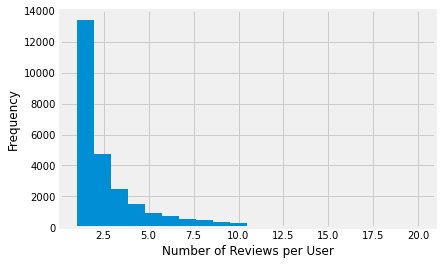

In [59]:
fig, ax = plt.subplots()
ax.hist(user_counts, bins=20)
ax.set_xlabel('Number of Reviews per User')
ax.set_ylabel('Frequency');

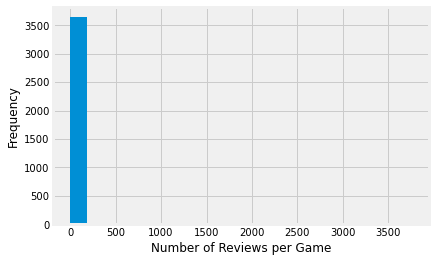

In [60]:
fig, ax = plt.subplots()
ax.hist(game_counts, bins=20)
ax.set_xlabel('Number of Reviews per Game')
ax.set_ylabel('Frequency');

## User Items

In [61]:
users_items_rdd = sc.textFile('data/australian_users_items (2).json')

In [62]:
users_items_rdd.count()

88310

In [63]:
users_items_rdd.first()

'{\'user_id\': \'76561197970982479\', \'items_count\': 277, \'steam_id\': \'76561197970982479\', \'user_url\': \'http://steamcommunity.com/profiles/76561197970982479\', \'items\': [{\'item_id\': \'10\', \'item_name\': \'Counter-Strike\', \'playtime_forever\': 6, \'playtime_2weeks\': 0}, {\'item_id\': \'20\', \'item_name\': \'Team Fortress Classic\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'30\', \'item_name\': \'Day of Defeat\', \'playtime_forever\': 7, \'playtime_2weeks\': 0}, {\'item_id\': \'40\', \'item_name\': \'Deathmatch Classic\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'50\', \'item_name\': \'Half-Life: Opposing Force\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'60\', \'item_name\': \'Ricochet\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'70\', \'item_name\': \'Half-Life\', \'playtime_forever\': 0, \'playtime_2weeks\': 0}, {\'item_id\': \'130\', \'item_name\': \'Half-Life: Blue Shif

In [64]:
users_items_rdd= users_items_rdd.map(lambda x: ast.literal_eval(x))

In [65]:
users_items_rdd.first()

{'user_id': '76561197970982479',
 'items_count': 277,
 'steam_id': '76561197970982479',
 'user_url': 'http://steamcommunity.com/profiles/76561197970982479',
 'items': [{'item_id': '10',
   'item_name': 'Counter-Strike',
   'playtime_forever': 6,
   'playtime_2weeks': 0},
  {'item_id': '20',
   'item_name': 'Team Fortress Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '30',
   'item_name': 'Day of Defeat',
   'playtime_forever': 7,
   'playtime_2weeks': 0},
  {'item_id': '40',
   'item_name': 'Deathmatch Classic',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '50',
   'item_name': 'Half-Life: Opposing Force',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '60',
   'item_name': 'Ricochet',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '70',
   'item_name': 'Half-Life',
   'playtime_forever': 0,
   'playtime_2weeks': 0},
  {'item_id': '130',
   'item_name': 'Half-Life: Blue Shift',
   'playtime_forever

In [66]:
users_items = users_items_rdd.toDF()

/usr/local/spark/python/pyspark/sql/session.py:398: UserWarning: Using RDD of dict to inferSchema is deprecated. Use pyspark.sql.Row instead
  warnings.warn("Using RDD of dict to inferSchema is deprecated. "


In [68]:
users_items.show(1)

+--------------------+-----------+-----------------+-----------------+--------------------+
|               items|items_count|         steam_id|          user_id|            user_url|
+--------------------+-----------+-----------------+-----------------+--------------------+
|[[item_name -> Co...|        277|76561197970982479|76561197970982479|http://steamcommu...|
+--------------------+-----------+-----------------+-----------------+--------------------+
only showing top 1 row



In [89]:
users_items.agg(countDistinct(col("user_id")).alias("count")).show()

+-----+
|count|
+-----+
|87626|
+-----+



In [94]:
columns_to_drop = ['steam_id', 'user_url']
users_items = users_items.drop(*columns_to_drop)

In [95]:
users_items.show(1)

+--------------------+-----------+-----------------+
|               items|items_count|          user_id|
+--------------------+-----------+-----------------+
|[[item_name -> Co...|        277|76561197970982479|
+--------------------+-----------+-----------------+
only showing top 1 row



In [101]:
users_items_user_id = users_items.select('user_id').toPandas()

#### Check the intersection of Users from Reviews and Items

In [119]:
user_reviews_pd.user_id.isin(users_items_user_id.user_id).astype(int)

0        1
1        1
2        1
3        1
4        1
        ..
59300    1
59301    1
59302    1
59303    1
59304    1
Name: user_id, Length: 59305, dtype: int64

In [121]:
users_items_user_id.nunique()

user_id    87626
dtype: int64

In [130]:
boolean = users_items_user_id['user_id'].duplicated()

In [131]:
boolean

0        False
1        False
2        False
3        False
4        False
         ...  
88305    False
88306    False
88307    False
88308    False
88309    False
Name: user_id, Length: 88310, dtype: bool

In [132]:
users_items_user_id[boolean]

,user_id
865,bokkkbokkk
1732,Nikiad
2343,76561198079743094
2344,ImSeriouss
2394,76561198069124937
...,...
48944,76561198035336388
67355,76561198071790027
69344,darkus0haos
73424,76561198080057659


In [135]:
users_items_user_id[users_items_user_id.user_id == 'darkus0haos']

,user_id
69343,darkus0haos
69344,darkus0haos


In [69]:
ex_items = users_items.select(explode("items").alias("i"))
flatten_items = ex_items.selectExpr('i.item_name', 'i.playtime_forever', 'i.playtime_2week')

flatten_items.show()


+--------------------+----------------+--------------+
|           item_name|playtime_forever|playtime_2week|
+--------------------+----------------+--------------+
|      Counter-Strike|               6|          null|
|Team Fortress Cla...|               0|          null|
|       Day of Defeat|               7|          null|
|  Deathmatch Classic|               0|          null|
|Half-Life: Opposi...|               0|          null|
|            Ricochet|               0|          null|
|           Half-Life|               0|          null|
|Half-Life: Blue S...|               0|          null|
|Day of Defeat: So...|            4733|          null|
|Counter-Strike: S...|            1853|          null|
|         Psychonauts|             333|          null|
|      Call of Duty 2|              75|          null|
|Sid Meier's Civil...|             338|          null|
|Sid Meier's Civil...|               0|          null|
|Sid Meier's Pirates!|               2|          null|
|    Joint

In [70]:
flatten_items.agg(countDistinct(col("item_name")).alias("count")).show()

+-----+
|count|
+-----+
|10947|
+-----+



In [ ]:
flatten_items.agg(countDistinct(col("item_name")).alias("count")).show()

## Reviews

In [74]:
reviews_rdd = sc.textFile('data/steam_reviews.json')

In [75]:
reviews_rdd.count()

7793069

In [76]:
reviews_rdd.first()

"{u'username': u'Chaos Syren', u'hours': 0.1, u'products': 41, u'product_id': u'725280', u'page_order': 0, u'date': u'2017-12-17', u'text': u'This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain.', u'early_access': False, u'page': 1}"

In [77]:
reviews_rdd= reviews_rdd.map(lambda x: ast.literal_eval(x))

In [78]:
reviews_rdd.take(10)

[{'username': 'Chaos Syren',
  'hours': 0.1,
  'products': 41,
  'product_id': '725280',
  'page_order': 0,
  'date': '2017-12-17',
  'text': 'This would not be acceptable as an entertainment even back in the day when these graphics were all there was to be had. No effort has been made to bring the player into any story or even entertain.',
  'early_access': False,
  'page': 1},
 {'username': '₮ʜᴇ Wᴀʀᴛᴏɴ',
  'hours': 51.1,
  'products': 769,
  'product_id': '328100',
  'page_order': 0,
  'date': '2017-12-27',
  'text': 'looks like a facebook game',
  'early_access': False,
  'page': 1},
 {'username': 'hello?<',
  'text': 'Better than Minecraft',
  'hours': 14.6,
  'date': '2017-10-16',
  'early_access': False,
  'found_funny': 2,
  'product_id': '328100',
  'page_order': 1,
  'compensation': 'Product received for free',
  'products': 2,
  'page': 1},
 {'username': 'Cyderine916',
  'hours': 5.0,
  'products': 64,
  'product_id': '35140',
  'page_order': 0,
  'date': '2018-01-04',
  'tex

In [79]:
reviews = reviews_rdd.toDF()

In [80]:
reviews.show(5)

+----------+------------+-----+----+----------+----------+--------+--------------------+--------------+
|      date|early_access|hours|page|page_order|product_id|products|                text|      username|
+----------+------------+-----+----+----------+----------+--------+--------------------+--------------+
|2017-12-17|       false|  0.1|   1|         0|    725280|      41|This would not be...|   Chaos Syren|
|2017-12-27|       false| 51.1|   1|         0|    328100|     769|looks like a face...|    ₮ʜᴇ Wᴀʀᴛᴏɴ|
|2017-10-16|       false| 14.6|   1|         1|    328100|       2|Better than Minec...|       hello?<|
|2018-01-04|       false|  5.0|   1|         0|     35140|      64|I love and idoliz...|   Cyderine916|
|2018-01-04|       false| 16.6|   1|         1|     35140|     577|Still worth playi...|DarklyThinking|
+----------+------------+-----+----+----------+----------+--------+--------------------+--------------+
only showing top 5 rows



In [81]:
reviews.agg(countDistinct(col("product_id")).alias("count")).show()

+-----+
|count|
+-----+
|15474|
+-----+



In [ ]:
reviews_pd = reviews

In [88]:
user_reviews.user_id.isin(reviews.username).sum()

TypeError: 'Column' object is not callable